In [1]:
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
import codecs

In [2]:
sentences = []
fileAllRecords = codecs.open (r'Path.txt',
            "r",  encoding = 'utf-8')

allStrings = fileAllRecords.readlines()
new_file = codecs.open(r'Path', 'w',   encoding = 'utf-8')

for string in allStrings:
    if len(string) > 20:
        new_file.write(string)

full_new_corpus = open(r'Path.txt', 'r',  encoding = 'utf-8')
lines = full_new_corpus.readlines()

In [3]:

import re 
import pymorphy2

def lemmatization_samples(samples):
    morph = pymorphy2.MorphAnalyzer()
    new_samples = []
    for s in samples:
        new_s = ""
        for w in s.split():
            r = re.compile("[^а-zА-Z]+")
            w = r.sub('', w).lower()
            w = morph.parse(w)[0].normal_form
            new_s += w + " "
        new_samples.append(new_s)
    return new_samples

sentences = lemmatization_samples(sentences) 

In [4]:
for sent_str in lines:
    tokens = re.sub("[a-z0-9]+.,´-", " ", sent_str.lower()).split()
    sentences.append(tokens)

from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, vector_size=50, window=4, min_count=3, workers=4, sg=0)
model.train(sentences, total_examples=len(sentences), epochs=100)
model.save('model.bin')

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras import optimizers

from keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

import pandas
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer



In [6]:
#get data in words
some_data = pandas.read_csv(r"test.csv",
                            sep=' ; ', encoding = 'utf-8', engine='python', index_col=False)

labels = some_data.iloc[:,0]
samples = some_data.iloc[:,1]

num_of_diagnoses = len(set(labels))

#convert labels to categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
Y_encoded = np_utils.to_categorical(encoded_labels)

In [7]:
def preprocessing_samples(samples):
    morph = pymorphy2.MorphAnalyzer()
    new_samples = []
    for s in samples:
        new_s = ""
        for w in s.split():
            r = re.compile("[^a-zA-Z ]+")
            w = r.sub('', w).lower()
            w = morph.parse(w)[0].normal_form  
            new_s += w + " "
        new_samples.append(new_s)
    return new_samples

samples = preprocessing_samples(samples) 


In [8]:
#Word2Vec load
def words_in_sample(samples):
    """Max number of words in one sample"""
    max_len = 0
    for sample in samples:
        cur_sample = sample.split()
        max_len = len(cur_sample) if len(cur_sample) > max_len else max_len
    return max_len

max_words_in_sample = words_in_sample(samples)
#load word2vec model
from gensim.models import Word2Vec, KeyedVectors

# my model
word2vecModel = Word2Vec.load("model.bin")


In [9]:
from collections import defaultdict
modelWord_from_word = dict()

for inx in range(len(word2vecModel.wv.key_to_index)):
    modelWord_from_word[word2vecModel.wv.index_to_key[inx].split('_')[0]] = word2vecModel.wv.index_to_key[inx]

from keras.preprocessing.text import text_to_word_sequence
def get_embedded_samples(samples, word2vecModel, words_in_sample):
    """get word2vec embeddings for given samples and words absent in given word2vec model"""
    new_x = np.zeros((len(samples), word2vecModel.vector_size*words_in_sample))
    absent_words = []
    i = 0 
    for sample in samples:
        current_sample = text_to_word_sequence(sample)
        newcur_x = np.zeros((1, word2vecModel.vector_size*max_words_in_sample))
        j = 0
        for word in current_sample:
            if word in modelWord_from_word:
                newcur_x[:, j:j+word2vecModel.vector_size] = (word2vecModel.wv[modelWord_from_word[word]])
                j += word2vecModel.vector_size
            else:
                absent_words.append(word)
        new_x[i] = newcur_x
        i += 1
    return new_x, absent_words

new_x, absentWords = get_embedded_samples(samples, word2vecModel, max_words_in_sample)

In [10]:
def create_network():
    model_CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu',
               input_shape=(max_words_in_sample,
                            word2vecModel.vector_size,
                            1),
               data_format="channels_last"),
        MaxPooling2D((2,2), padding='same'),
        Dropout(0.25),

        Conv2D(64, (2, 2), activation='relu'),
        MaxPooling2D((2,2), padding='same'),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_of_diagnoses, activation='softmax')])

    model_CNN.compile(optimizer=RMSprop(lr=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return model_CNN


Epoch 1/10
1/1 [==============================] - 1s 816ms/step - loss: 3.2444 - accuracy: 0.1176 - val_loss: 3.5865 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 2.7458 - accuracy: 0.1176 - val_loss: 3.8463 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 2.7483 - accuracy: 0.1176 - val_loss: 3.7823 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 51ms/step - loss: 2.5846 - accuracy: 0.2941 - val_loss: 4.0130 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 50ms/step - loss: 2.4616 - accuracy: 0.2353 - val_loss: 4.0984 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 57ms/step - loss: 2.1347 - accuracy: 0.4706 - val_loss: 4.3427 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 2.3721 - accuracy: 0.3529 - val_loss: 4.5549 - val_accuracy: 0.0000e+0

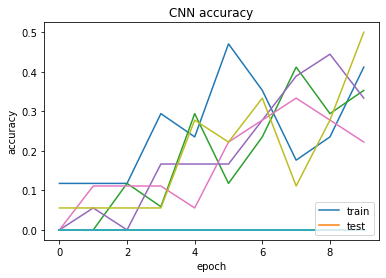

In [12]:
n_splits = 5
n_epochs = 10

x_CNN = new_x.reshape(new_x.shape[0], max_words_in_sample, word2vecModel.vector_size, 1)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
kf.get_n_splits(x_CNN)

f1_score_all = []
for train_index, test_index in kf.split(x_CNN):
    X_train, X_test = x_CNN[train_index], x_CNN[test_index]
    y_train, y_test = Y_encoded[train_index], Y_encoded[test_index]

    model_CNN = create_network()

    history_CNN = model_CNN.fit(X_train, y_train,
                                epochs=n_epochs,
                                verbose=1,
                                batch_size = 128,
                                validation_data=(X_test, y_test))

    # summarize history for accuracy
    plt.plot(history_CNN.history['accuracy'])
    plt.plot(history_CNN.history['val_accuracy'])
    plt.title('CNN accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')